# Temperature and flow solutions

In [10]:
%load_ext autoreload
%autoreload 2
%run ct_data.py '../crunchtope_model/results.nc' -c pH totcon
%run pf_data.py '../pflotran_model/little_dev_model/flow_steady_state/steady_flow.h5'
%run figures.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Error: The following variables are not in the xarray object: ['Forsterite_VF', 'Fayalite_VF']. Mineral not found.


In [11]:
pf_data['Liquid Z-Velocity'].sel(z=1500, time=1000, method='nearest')

<xarray.DataArray 'Liquid Z-Velocity' (x: 32, y: 1)> Size: 256B
array([[ 3.20222417e+00],
       [ 1.04693545e-02],
       [ 2.44540844e-03],
       [ 3.29056667e-04],
       [ 1.24842799e+00],
       [ 1.72615954e-01],
       [-2.24272312e-01],
       [-3.66515074e-01],
       [-4.20195330e-01],
       [-4.31237630e-01],
       [-4.24664882e-01],
       [-4.13037564e-01],
       [-4.01579503e-01],
       [-3.92552146e-01],
       [-3.86928607e-01],
       [-3.85064534e-01],
       [-3.86972186e-01],
       [-3.92397386e-01],
       [-4.00783708e-01],
       [-4.11168642e-01],
       [-4.22001720e-01],
       [-4.30933446e-01],
       [-4.34756779e-01],
       [-4.29945454e-01],
       [-4.14585081e-01],
       [-3.88776593e-01],
       [-3.48730030e-01],
       [-2.74292084e-01],
       [-1.13562776e-01],
       [ 4.31036116e-01],
       [ 1.41913861e+00],
       [ 2.35963069e+00]])
Coordinates:
    time     float64 8B 1e+03
  * x        (x) float64 256B 23.44 70.31 117.2 ... 1.383e+03 1.43e+03 1.477e+03
  * y        (y) float64 8B 50.0
    z        float64 8B 1.477e+03
Attributes:
    units:    m_per_y

In [12]:
pf_data['Liquid X-Velocity'].sel(z=1500, time=1000, method='nearest')

<xarray.DataArray 'Liquid X-Velocity' (x: 32, y: 1)> Size: 256B
array([[-2.91188062e-03],
       [-2.94126759e-03],
       [-2.77599102e-03],
       [-2.76061707e-03],
       [ 1.81344700e-01],
       [ 3.24081154e-01],
       [ 2.09076378e-01],
       [ 9.18531841e-02],
       [ 3.00928160e-02],
       [ 5.55821903e-03],
       [-2.95969329e-03],
       [-5.15359045e-03],
       [-4.86708522e-03],
       [-3.56033494e-03],
       [-1.84248557e-03],
       [-3.66849512e-06],
       [ 1.78087491e-03],
       [ 3.35709181e-03],
       [ 4.54015316e-03],
       [ 5.07662085e-03],
       [ 4.62205034e-03],
       [ 2.77129208e-03],
       [-8.04708603e-04],
       [-6.06689555e-03],
       [-1.29913717e-02],
       [-2.42871671e-02],
       [-5.10371222e-02],
       [-1.17121575e-01],
       [-2.29189735e-01],
       [-3.25627438e-01],
       [-3.14066064e-01],
       [-2.71416465e-01]])
Coordinates:
    time     float64 8B 1e+03
  * x        (x) float64 256B 23.44 70.31 117.2 ... 1.383e+03 1.43e+03 1.477e+03
  * y        (y) float64 8B 50.0
    z        float64 8B 1.477e+03
Attributes:
    units:    m_per_y

Text(0, 0.5, 'Z Coordinate')

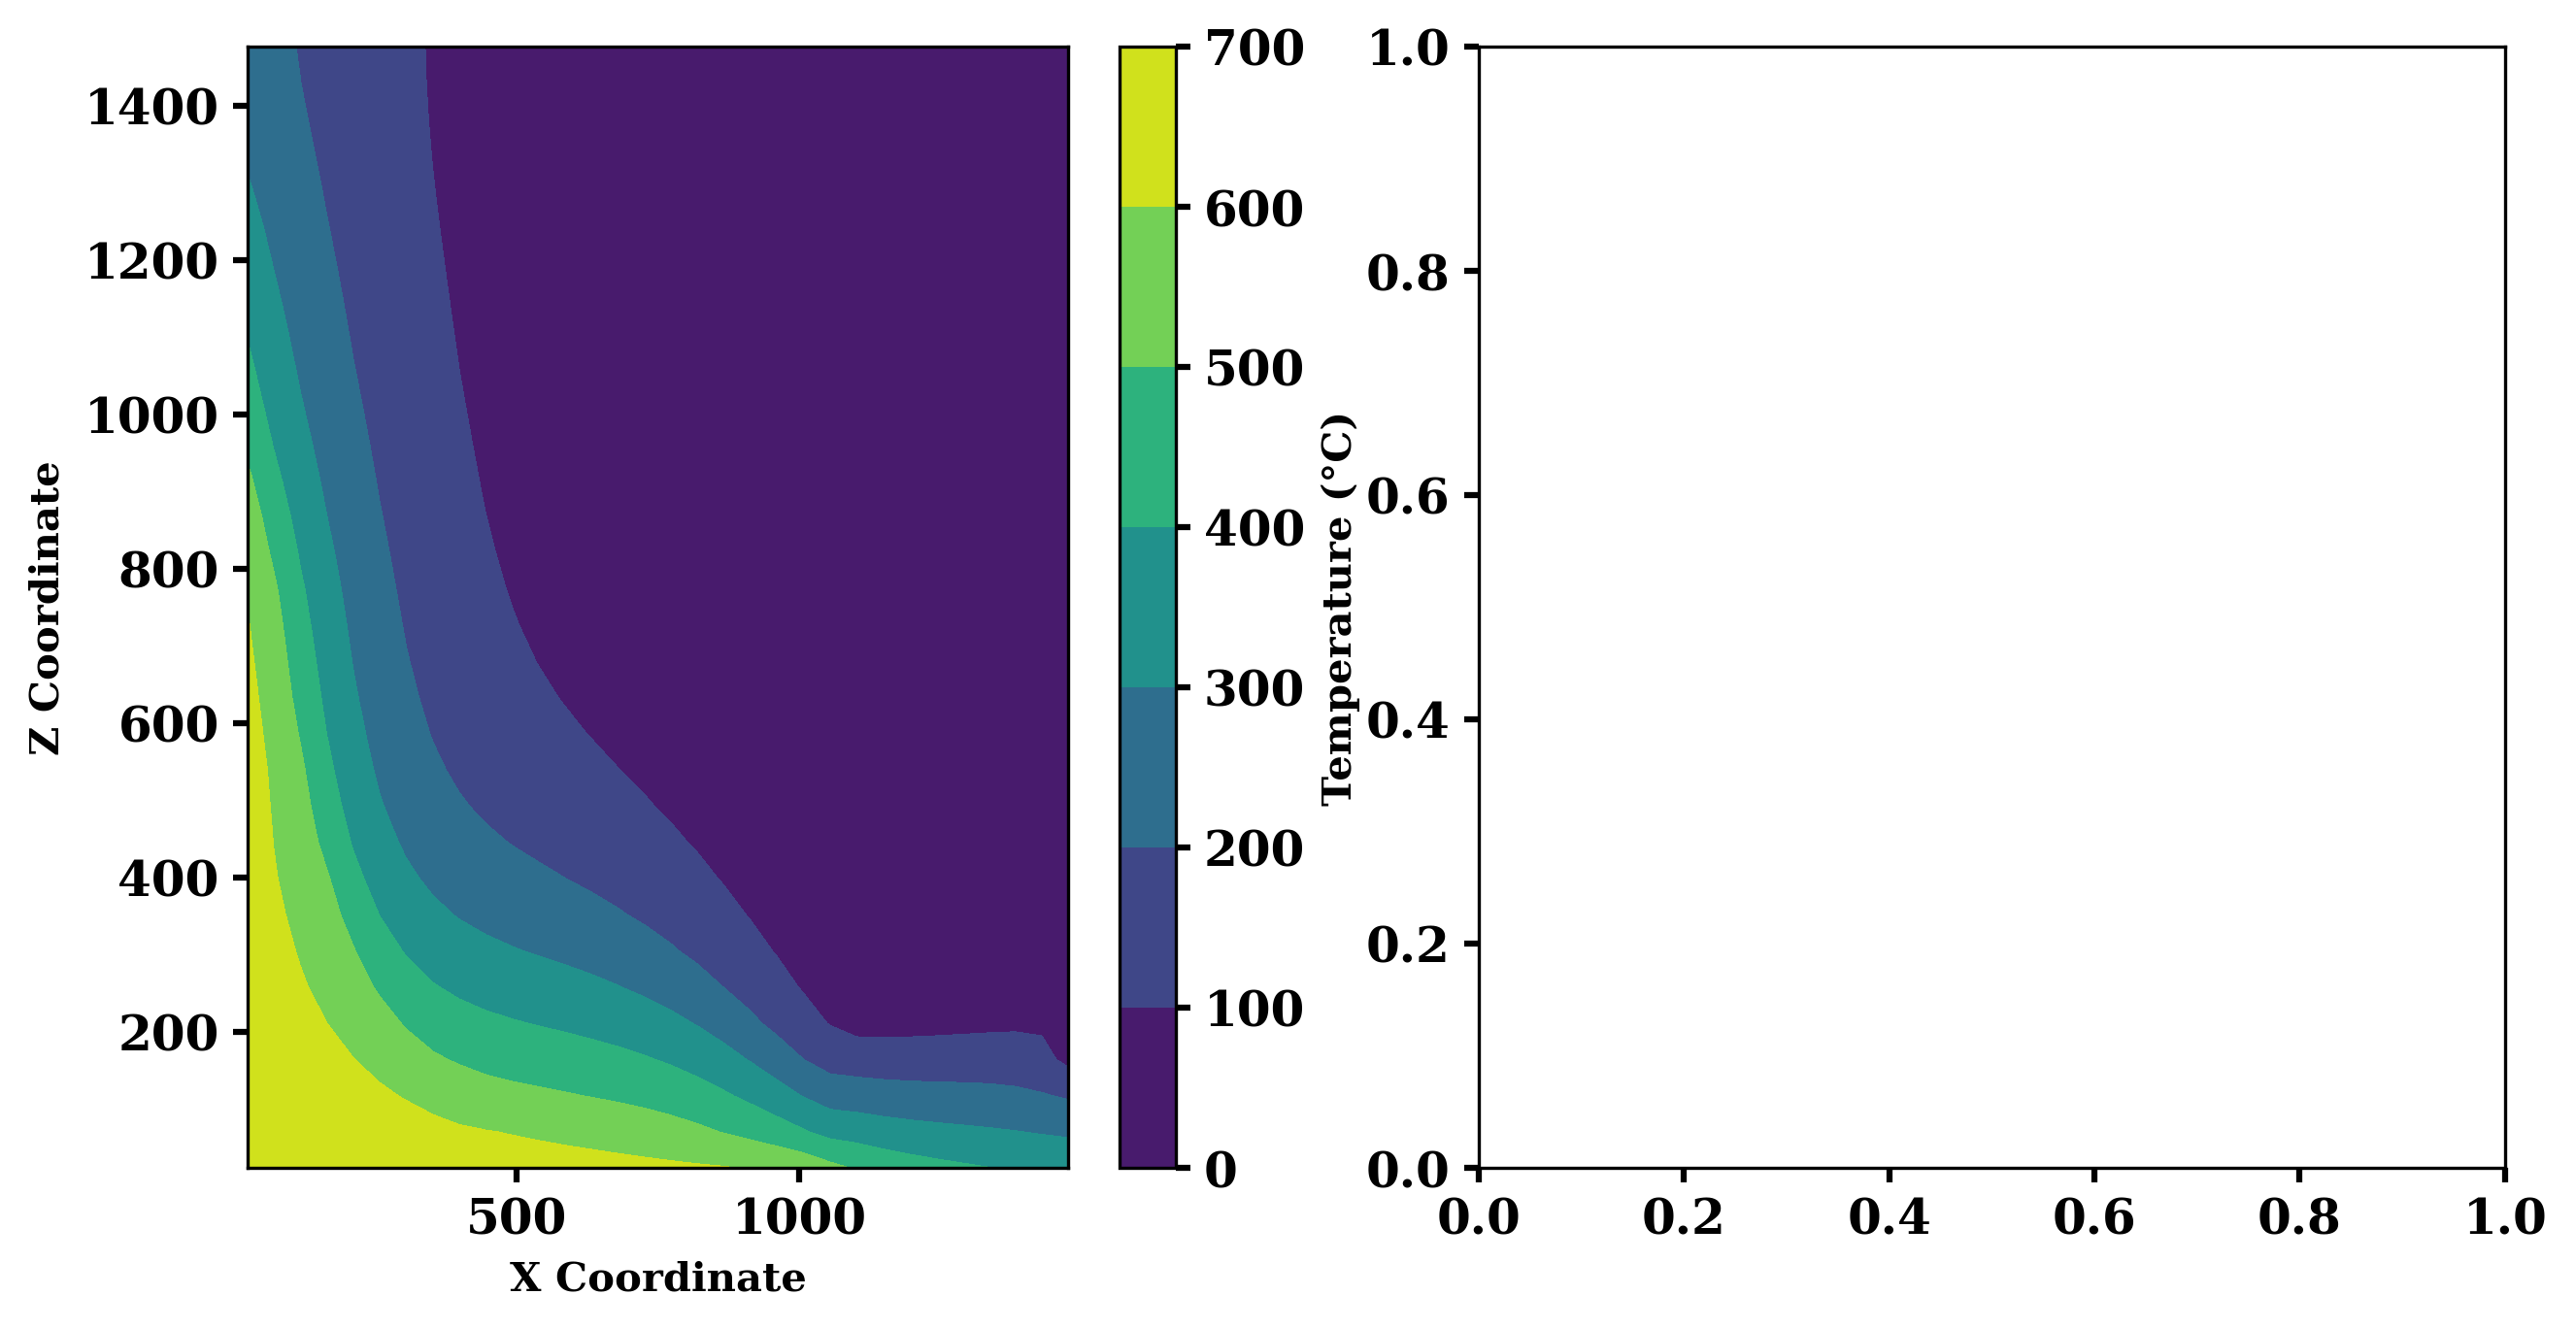

In [13]:
import matplotlib.pyplot as plt
plt.style.use('custom.mplstyle')
import xarray as xr

ds = pf_data

# Assuming 'ds' is your xarray dataset and 'temperature' is the variable of interest
# Replace 'ds' with the actual dataset name
temperature = ds.Temperature.isel(y=0, time=-1)

# Extract X and Z spatial coordinates
x = ds.coords['x']  # Replace 'X' with actual x-coordinate name if different
z = ds.coords['z']  # Replace 'Z' with actual z-coordinate name if different

# Create the contour plot
fig, ax = plt.subplots(1,2, figsize=(10, 5))
contour = ax[0].contourf(x, z, temperature, cmap='viridis')

# Add color bar for temperature
fig.colorbar(contour, label='Temperature (°C)')

# Label axes
ax[0].set_xlabel('X Coordinate')
ax[0].set_ylabel('Z Coordinate')



In [22]:
import numpy as np

x_velocity_slice = ds['Liquid X-Velocity'].isel(y=0).sel(time=1000, method='nearest').values
z_velocity_slice = ds['Liquid Z-Velocity'].isel(y=0).sel(time=1000, method='nearest').values

# Extract X and Z coordinates
x = ds.coords['x'].values
z = ds.coords['z'].values

X, Z = np.meshgrid(x, z)

# Create the quiver (vector) plot
ax[1].streamplot(x, z, u=x_velocity_slice, v=z_velocity_slice)

# Label the axes
ax[1].set_xlabel('X Coordinate')
ax[1].set_ylabel('Z Coordinate')

fig.tight_layout()
fig.savefig('output/figure_s2.png', dpi=300)


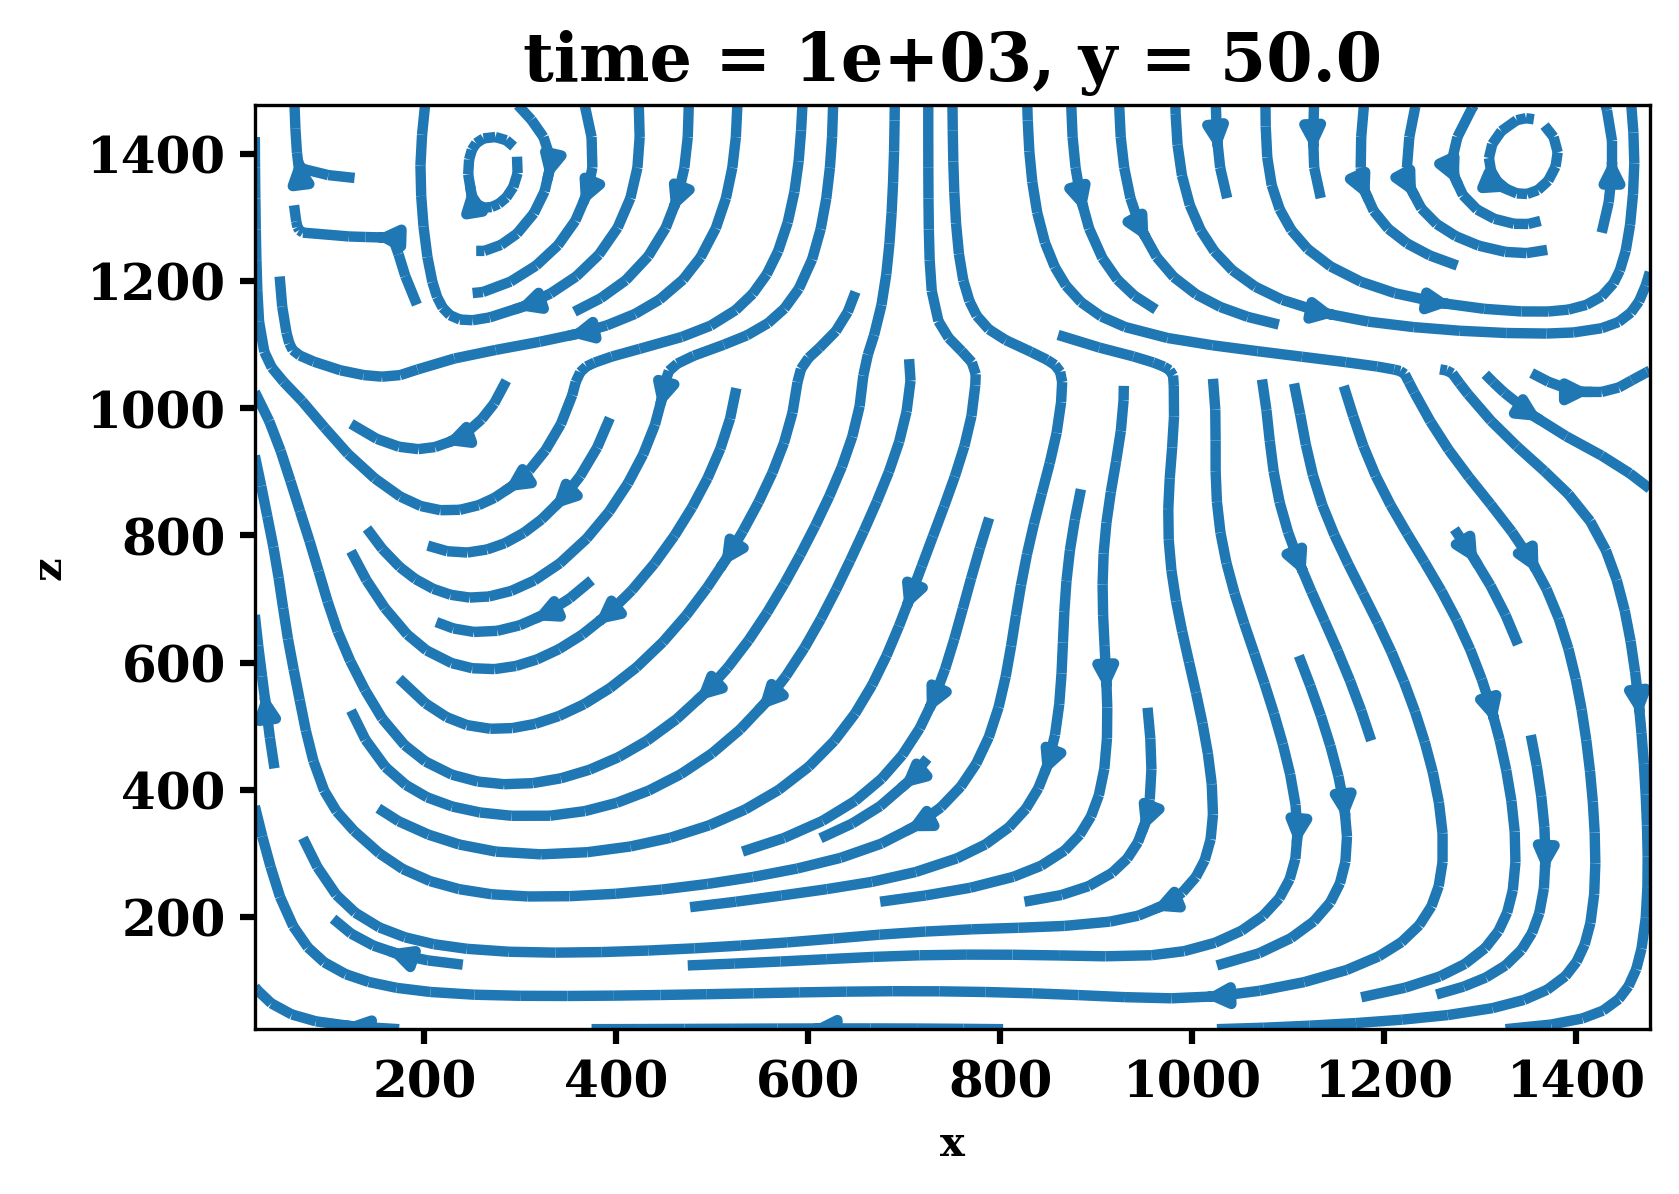

In [15]:
pf_data.sel(y=50,time=1000).plot.streamplot(x='x', y='z', u='Liquid X-Velocity', v='Liquid Z-Velocity')
plt.show()

In [ ]:
def plot_flux(ax, concentrations, data, range_sets, legend_entries, crunchtope=False):
    if crunchtope:
        dims = ['X', 'Y', 'Z']
    else:
        dims = ['x', 'y', 'z']
    for conc_range, range_set, legend_entry in zip(concentrations, range_sets, legend_entries):
        # Processing data
        extracted_data = data.sel(time=time).isel(file_num=slice(range_set[0], range_set[1] + 1)).sum(dim=dims)
        ax.plot(conc_range, extracted_data, label=legend_entry)

In [ ]:

time=1000

def total_volume(data, mineral):
    # Sum variables over all coordinates and select the final time 
    total_vf = data.sum(dim=('x','y','z')).sel(time=time)[mineral].to_numpy()
    print(total_vf)
    total_volume = total_vf * 46.9 * 46.9 * 100 # m^3 

    return total_volume

def volume_to_moles(volume, molar_volume):
    moles = volume / molar_volume
    return moles

[0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321
 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321
 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321
 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321
 0.0980321]
[0.30463172 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172
 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172
 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172
 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172
 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172]


In [16]:
x_velocity_slice.squeeze().values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [20]:
x


<xarray.DataArray 'x' (x: 32)> Size: 256B
array([  23.4375,   70.3125,  117.1875,  164.0625,  210.9375,  257.8125,
        304.6875,  351.5625,  398.4375,  445.3125,  492.1875,  539.0625,
        585.9375,  632.8125,  679.6875,  726.5625,  773.4375,  820.3125,
        867.1875,  914.0625,  960.9375, 1007.8125, 1054.6875, 1101.5625,
       1148.4375, 1195.3125, 1242.1875, 1289.0625, 1335.9375, 1382.8125,
       1429.6875, 1476.5625])
Coordinates:
  * x        (x) float64 256B 23.44 70.31 117.2 ... 1.383e+03 1.43e+03 1.477e+03